# Deep dive on Overscan

In [22]:
%matplotlib notebook

In [75]:
# imports
import os
import numpy as np
from matplotlib import pyplot as plt
from importlib import reload

from scipy import signal

from astropy.io import fits
from astropy.stats import sigma_clipped_stats

from desispec import preproc

In [4]:
exp_path = '/home/xavier/DESI/Commissioning/exposures'

In [6]:
night = '20190619'

# Methods

In [8]:
def add_gain(header, SP='sp2'):
    if SP=='sp2':
        header['GAINA'] = 1.21763880607
        header['GAINB'] = 1.26599257375
        header['GAINC'] = 1.37207665312
        header['GAIND'] = 1.28793077884

In [68]:
def get_oscan_col(rawimage, header, amp='A'):
    ov_col = preproc._parse_sec_keyword(header['BIASSEC'+amp])
    raw_overscan_col = rawimage[ov_col].copy()
    vals = []
    for row in range(raw_overscan_col.shape[0]):
        o, _ = preproc._overscan(raw_overscan_col[row,:])
        vals.append(o)
    overscan_col = np.array(vals)
    return overscan_col

In [71]:
def get_oscan_row(rawimage, header, amp='A'):
    ov_row_idx = preproc._parse_sec_keyword(header['ORSEC'+amp])
    raw_overscan_row = rawimage[ov_row_idx].copy()
    vals = []
    for col in range(raw_overscan_row.shape[1]):
        o, _ = preproc._overscan(raw_overscan_row[:,col])
        vals.append(o)
    overscan_row = np.array(vals)
    return overscan_row

# 10s exposure

In [7]:
iid = 16287
ifile = os.path.join(exp_path, night, '000{}'.format(iid), 'desi-000{}.fits.fz'.format(iid))
ifile

'/home/xavier/DESI/Commissioning/exposures/20190619/00016287/desi-00016287.fits.fz'

In [10]:
hdulist = fits.open(ifile)

## z2

In [11]:
z2_hdu_10 = hdulist['z2']

### Examine overscan_column

In [18]:
header = z2_hdu_10.header
rawimage = z2_hdu_10.data.astype(np.float64)

In [14]:
amp = 'A'

In [15]:
ov_col = preproc._parse_sec_keyword(header['BIASSEC'+amp])

In [20]:
raw_overscan_col = rawimage[ov_col].copy()
raw_overscan_col.shape

(2064, 64)

In [27]:
vals = []
for row in range(raw_overscan_col.shape[0]):
    o, _ = preproc._overscan(raw_overscan_col[row,:])
    vals.append(o)
overscan_col = np.array(vals)
overscan_col.shape

(2064,)

<IPython.core.display.Javascript object>


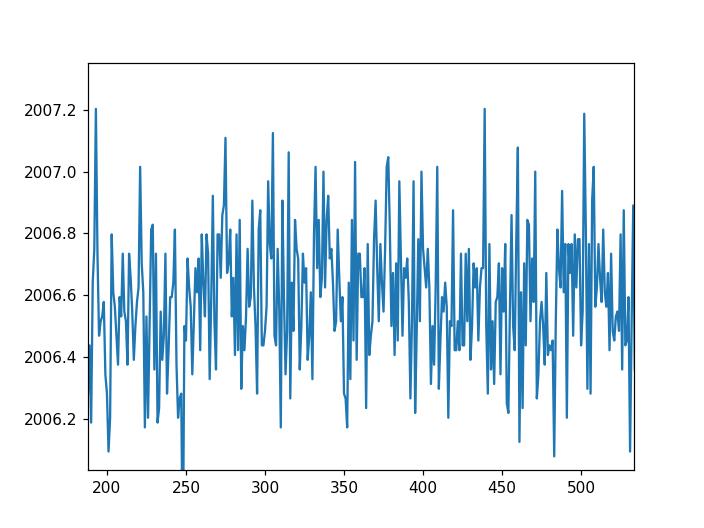

In [28]:
# Plot
plt.clf()
ax = plt.gca()
ax.plot(overscan_col)
plt.show()

<IPython.core.display.Javascript object>


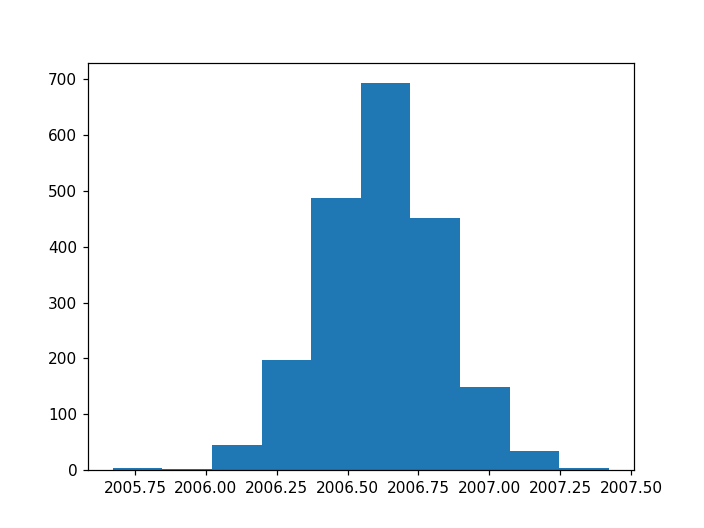

In [30]:
plt.clf()
ax = plt.gca()
ax.hist(overscan_col)
plt.show()

In [43]:
mean, med_sn2, stddev = sigma_clipped_stats(overscan_col,sigma_lower=3.0,sigma_upper=3.0)
stddev

0.2080538536241746

### Let's try a savgol

In [51]:
oscol_sub = signal.savgol_filter(overscan_col, 65, 5)

<IPython.core.display.Javascript object>


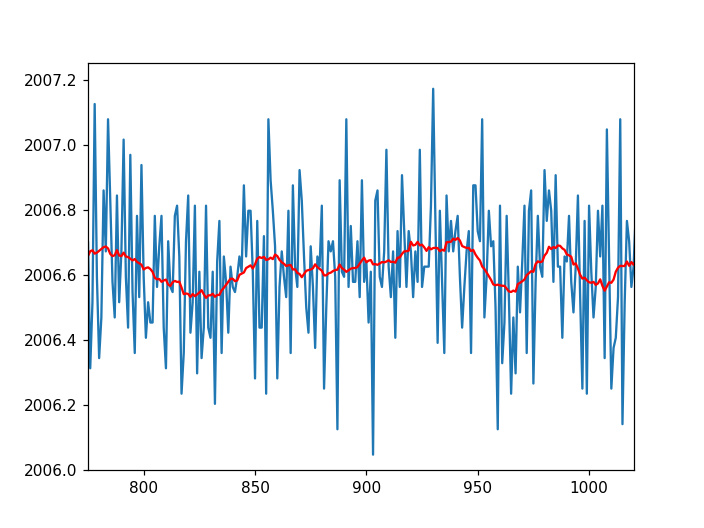

In [52]:
# Plot
plt.clf()
ax = plt.gca()
ax.plot(overscan_col)
ax.plot(oscol_sub, 'r-')
ax.set_xlim(775, 1020)
ax.set_ylim(2006., 2007.25)
plt.show()

<IPython.core.display.Javascript object>


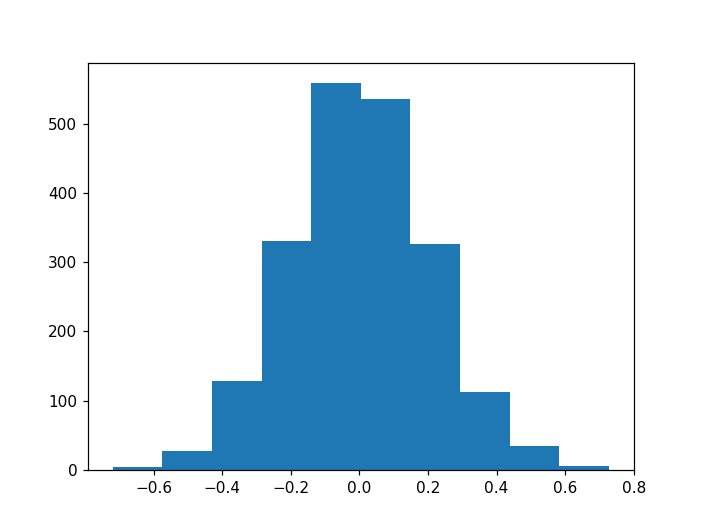

In [53]:
plt.clf()
ax = plt.gca()
ax.hist(overscan_col-oscol_sub)
plt.show()

In [54]:
mean, med_sn2, stddev_sub = sigma_clipped_stats(overscan_col-oscol_sub,sigma_lower=3.0,sigma_upper=3.0)
stddev_sub

0.19939938942624164

## Overscan row

In [44]:
ov_row_idx = preproc._parse_sec_keyword(header['ORSEC'+amp])

In [47]:
raw_overscan_row = rawimage[ov_row_idx].copy()
raw_overscan_row.shape

(32, 2057)

In [49]:
vals = []
for col in range(raw_overscan_row.shape[1]):
    o, _ = preproc._overscan(raw_overscan_row[:,col])
    vals.append(o)
overscan_row = np.array(vals)
overscan_row.shape

(2057,)

<IPython.core.display.Javascript object>


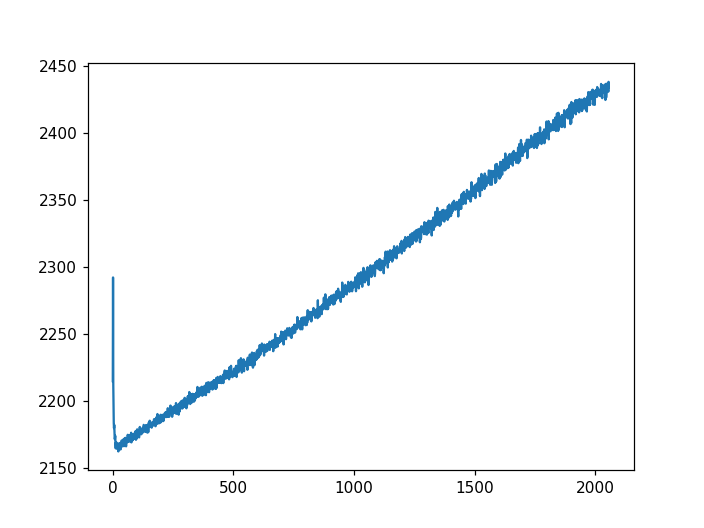

In [50]:
# Plot
plt.clf()
ax = plt.gca()
ax.plot(overscan_row)
plt.show()

### Sobolev

In [55]:
osrow_sub = signal.savgol_filter(overscan_row, 65, 5)

<IPython.core.display.Javascript object>


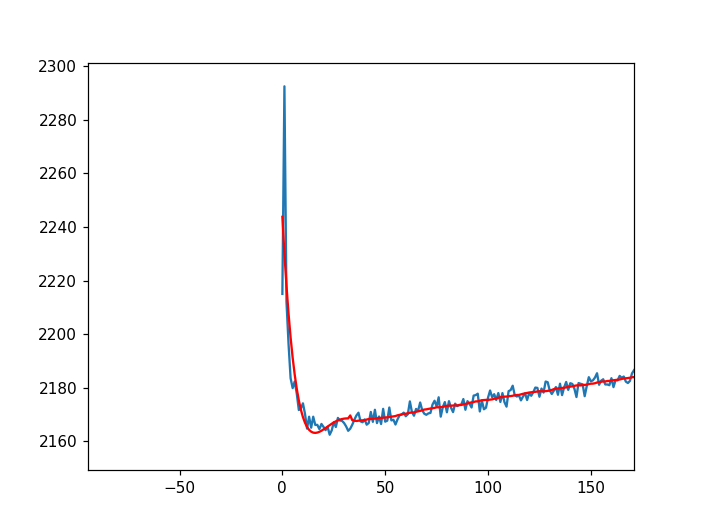

In [61]:
# Plot
plt.clf()
ax = plt.gca()
ax.plot(overscan_row)
ax.plot(osrow_sub, 'r-')
plt.show()

<IPython.core.display.Javascript object>


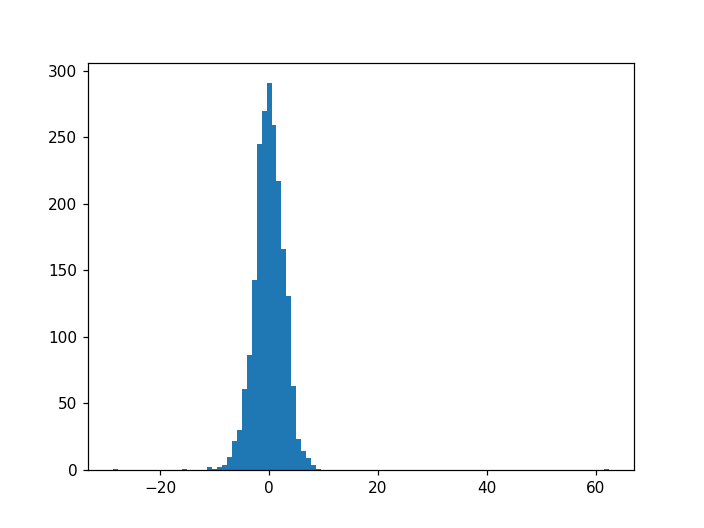

2.598601353934941

In [59]:
plt.clf()
ax = plt.gca()
ax.hist(overscan_row-osrow_sub, bins=100)
plt.show()
# Stats
mean, med_sn2, stddev_sub_row = sigma_clipped_stats(overscan_row-osrow_sub,sigma_lower=3.0,sigma_upper=3.0)
stddev_sub_row

# Explore a zero image

In [64]:
night = '20190620'
iid = 16394
ifile = os.path.join(exp_path, night, '000{}'.format(iid), 'desi-000{}.fits.fz'.format(iid))
ifile

'/home/xavier/DESI/Commissioning/exposures/20190620/00016394/desi-00016394.fits.fz'

In [65]:
hdulist = fits.open(ifile)

In [66]:
z2_zero = hdulist['z2']

In [67]:
header = z2_zero.header
rawimage = z2_zero.data.astype(np.float64)

## Overscan col

In [69]:
oscan_col = get_oscan_col(rawimage, header)

<IPython.core.display.Javascript object>


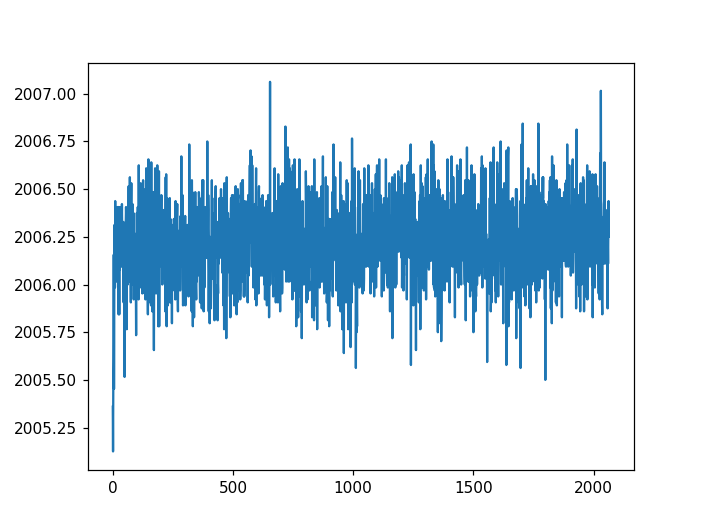

In [70]:
plt.clf()
ax = plt.gca()
ax.plot(oscan_col)
plt.show()

## Overscan row

In [72]:
oscan_row = get_oscan_row(rawimage, header)

ERROR:preproc.py:82:_overscan: error in sigma clipping for overscan measurement, return result without clipping


<IPython.core.display.Javascript object>


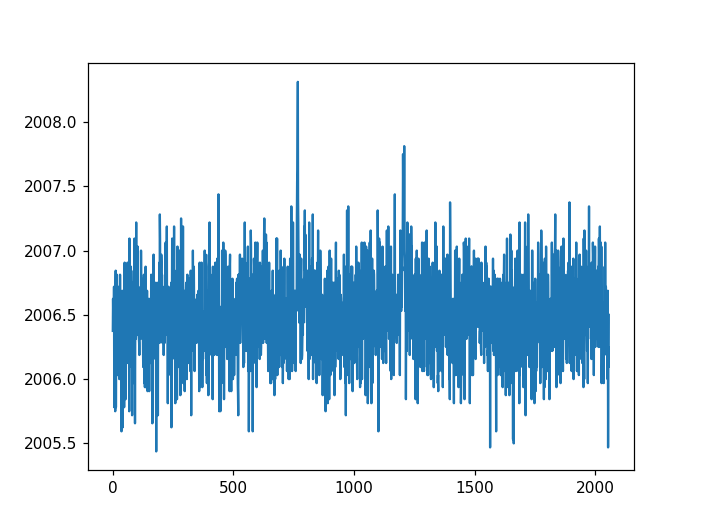

In [73]:
plt.clf()
ax = plt.gca()
ax.plot(oscan_row)
plt.show()

# Let's process with savgol

In [77]:
reload(preproc)
img_zero = preproc.preproc(rawimage, header, None, bias=False, pixflat=False, mask=False, 
                      nocrosstalk=True, ccd_calibration_filename=False, dark=False)

INFO:preproc.py:476:preproc: nrows in overscan=2064
INFO:preproc.py:490:preproc: Subtracting average overscan for amplifier A of camera z2
INFO:preproc.py:498:preproc: Median rdnoise and overscan= 1.738760 2006.222179
INFO:preproc.py:532:preproc: Measured readnoise for AMP A = 1.738760
INFO:preproc.py:476:preproc: nrows in overscan=2064
INFO:preproc.py:490:preproc: Subtracting average overscan for amplifier B of camera z2
INFO:preproc.py:498:preproc: Median rdnoise and overscan= 1.591893 2006.810721
INFO:preproc.py:532:preproc: Measured readnoise for AMP B = 1.591893
INFO:preproc.py:476:preproc: nrows in overscan=2064
INFO:preproc.py:490:preproc: Subtracting average overscan for amplifier C of camera z2
INFO:preproc.py:498:preproc: Median rdnoise and overscan= 1.839822 2009.040433
INFO:preproc.py:532:preproc: Measured readnoise for AMP C = 1.839822
INFO:preproc.py:476:preproc: nrows in overscan=2064
INFO:preproc.py:490:preproc: Subtracting average overscan for amplifier D of camera z2


In [81]:
img_zero.pix.shape

(4128, 4114)

In [84]:
#from pypeit import ginga
#ginga.show_image(img_zero.pix)

<IPython.core.display.Javascript object>


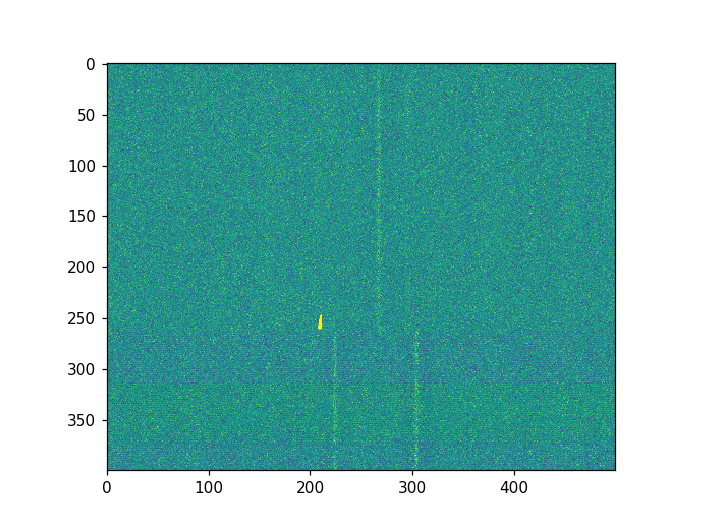

In [88]:
vmin, vmax = -9., 9.
plt.clf()
#plt.figure(figsize=(13,7))
plt.imshow(img_zero.pix[1800:2200,500:1000], vmin=vmin, vmax=vmax)
plt.show()

# Image 16727, r3

In [89]:
night = '20190627'
iid = 16727
ifile = os.path.join(exp_path, night, '000{}'.format(iid), 'desi-000{}.fits.fz'.format(iid))
ifile

'/home/xavier/DESI/Commissioning/exposures/20190627/00016727/desi-00016727.fits.fz'

In [90]:
hdulist = fits.open(ifile)
r3 = hdulist['r3']

In [91]:
reload(preproc)
img_r3 = preproc.preproc(r3.data, r3.header, None, bias=False, pixflat=False, mask=False, 
                      nocrosstalk=True, ccd_calibration_filename=False, dark=False)

INFO:preproc.py:476:preproc: nrows in overscan=2064
INFO:preproc.py:490:preproc: Subtracting average overscan for amplifier A of camera r3
INFO:preproc.py:498:preproc: Median rdnoise and overscan= 1.927896 2011.653812
INFO:preproc.py:532:preproc: Measured readnoise for AMP A = 1.927896
INFO:preproc.py:476:preproc: nrows in overscan=2064
INFO:preproc.py:490:preproc: Subtracting average overscan for amplifier B of camera r3
INFO:preproc.py:498:preproc: Median rdnoise and overscan= 1.868597 2006.213943
INFO:preproc.py:532:preproc: Measured readnoise for AMP B = 1.868597
INFO:preproc.py:476:preproc: nrows in overscan=2064
INFO:preproc.py:490:preproc: Subtracting average overscan for amplifier C of camera r3
INFO:preproc.py:498:preproc: Median rdnoise and overscan= 1.914334 2009.333311
INFO:preproc.py:532:preproc: Measured readnoise for AMP C = 1.914334
INFO:preproc.py:476:preproc: nrows in overscan=2064
INFO:preproc.py:490:preproc: Subtracting average overscan for amplifier D of camera r3


In [92]:
from pypeit import ginga
ginga.show_image(img_r3.pix)

(<ginga.util.grc.RemoteClient at 0x7f8515393b38>,
 <ginga.util.grc._channel_proxy at 0x7f85155e26a0>)

<IPython.core.display.Javascript object>


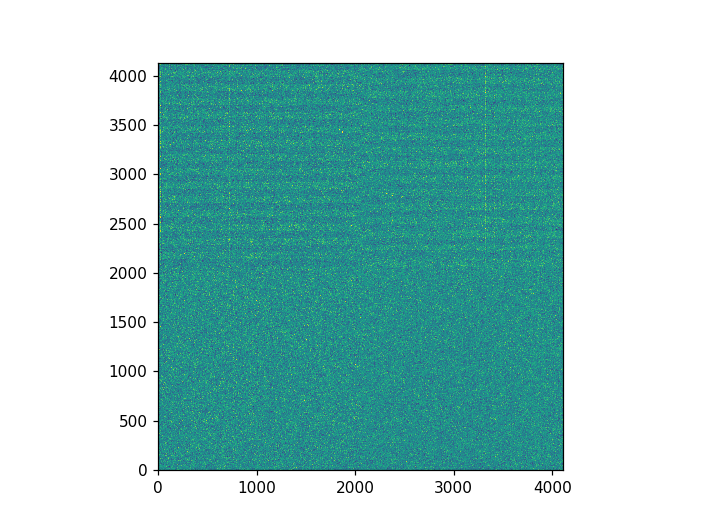

In [93]:
vmin, vmax = -9., 9.
plt.clf()
#plt.figure(figsize=(13,7))
plt.imshow(img_zero.pix, vmin=vmin, vmax=vmax, origin='lower')
plt.show()